## Overview

The main goal of the notebook is to understand what steps I have taken to gather image data, preprocess the data, and train the models, validate the models, and test the models on my webcam to see if it is fit for the game of Simon Says - which is the project that I ultimately want to build. I have not included in this notebook, the various experiments I did while changing the learning rate and various parameters when training the models.

This Notebook will consist of the following sections. 

* Initial Setup - Loading in required packages
    * Load the required packages right off the bat so that you can run the code in this notebook
* Image Data
    * Gathering the image data for this project. Preprocessing the data into training and validation sets. Cleaning the data.
* Experimenting with Various Models / Building Real Time Detector
    * Training various models to understand the strength and pitfalls of each, and to test the classification through stream on webcam computer.
   

## Initial Setup - Loading in required packages

* keras package - needed for constructing neural network (using tensorflow as backend)
* numpy package - used for data manipulation
* pandas package - used for data manipulation
* cv2 package - used for image processing
* os package - used for getting path to images
* matplotlib - used for plotting image example
* sklearn - used for statistics and creating train-test partition split

In [22]:
# load packages
import keras
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential

## Image Data

I have found images online through Google and Bing search which I used to train my models. I also had to take my own images because there was not enough training data with just images I found online. I have accumulated a total of 531 images. Initially, I did not have enough data and when I trained my models, the classification accuracy was very low. I added more data later on which increased my classification accuracy. There are ten different class labels in my dataset as listed below that are based upon human gestures.

1. Angry
2. Cross Arms to make an 'X'
3. Flex Biceps
4. Peace Sign
5. Smile
6. Stick out tounge
7. Hold up ten fingers
8. Touch Head
9. Touch Nose
10. Touch Shoulders

### Preprocessing the data

In this section we will read in the image data and create training and validation sets of that data. I will use 80% of data for training and 20% as validation. The images will be initally stored in a pandas dataframe as it is much faster to append image data to a pandas dataframe than a numpy array.

The images will also be grayscale. The reason that I will convert the colored (RGB) images to grayscale is because for this classification problem color is not useful in determining the various image classifications - it may lead to more innacurate classifications if I trained the model with colored image data.

I have saved the the images all in one folder, then will create the train and validation splits.

In [23]:
# list that has all the folder names/classifications
subfolder = ['angry', 'cross_armsX', 'flex_biceps', 'peace_sign', 'smile', 
            'stick_tounge', 'ten_fingers', 'touch_head', 'touch_nose', 'touch_shoulder']

# initialize empty pandas dataframe to store all images and respective class labels
image_df = pd.DataFrame()

# loop to read in the image data
for i in subfolder:
    path = 'D:/' + i # path to subfolder
    directory = os.listdir(path)  # read in the images in the subfolder
    
    # nested loop to read in each image in subfolder
    for k in directory:
        img = cv2.imread(path + '/' + k, 1) # read in image, convert to grayscale
        
        # resize the image to 300 width, 300 height
        #r = 300.0 / img.shape[1] # keep in mind aspect ratio to not distort image
        #dim = (300, int(img.shape[0] * r))
        img = cv2.resize(img, (300,300), interpolation = cv2.INTER_AREA)
        
        temp_df = pd.DataFrame({'label':[i], 'image': [img]}) # pandas dataframe that holds one record of image data
        image_df = image_df.append(temp_df) # append temp_df dataframe to image_df dataframe


In [24]:
# reset the index of the dataframe and display head
image_df = image_df.reset_index(drop = True)
image_df.head()

,image,label
0,"[[[230, 230, 230], [231, 231, 231], [231, 231,...",angry
1,"[[[52, 52, 52], [52, 52, 52], [54, 54, 54], [5...",angry
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",angry
3,"[[[223, 229, 224], [223, 229, 224], [223, 229,...",angry
4,"[[[62, 65, 70], [63, 66, 71], [64, 67, 72], [6...",angry


Class label: cross_armsX - (300, 300, 3)


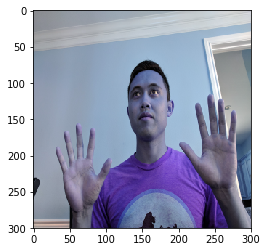

In [4]:
# display one image and its respective class label
pic = 71
img = image_df.image[pic]
lbl = image_df.label[pic]
%matplotlib inline
imgplot = plt.imshow(img)
print ('Class label:', lbl, '-', img.shape)

In [25]:
# store images and labels in numpy arrays
images = np.array(list(image_df.image)) / 255.0  # divide by 255 to have smaller values
labels = np.array(image_df.label)
le = LabelEncoder()  # one hot encode the labels, needed for neural net
labels = le.fit_transform(labels)
labels = keras.utils.to_categorical(labels, num_classes=None)

# create partition of training and validation sets, 20% validation
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 3)

In [6]:
# inspect encoded labels
y_train[0:2]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

## Experimenting with Various Models / Building Real Time Detector

### Training self-built model

Here we are initializing the structure of the neural network. I am building my own model to get the output classification accuracy. Now that we have the image data ready, I can start building my model.



In [215]:
# Initialize neural network
model = Sequential()

# The input layer of the neural network is the image array which will have the shape of 180px by 180px and have a depth of three.
# There will be 80 filters/nodes in the second layer. The kernel size will be four, which means that each filter will cover a 4px
# by 4px area to find a pattern. The filter will move across the image array two pixels at a time. Using the 'relu' activation
# function.
model.add(Conv2D(filters=80, kernel_size=4, strides=2, activation='relu', input_shape=(300, 300, 3)))

# Implementing a dropout so that we do not overfit any of the nodes in the second layer. This just means that we randomly turn 
# off some nodes in the second layer so that others can get trained as well.
model.add(Dropout(rate = 0.2))

# Implementing pooling layer so that we reduce the dimensionality of the array. So that we can focus in on more specific patterns
# in the array
model.add(MaxPooling2D(pool_size=2, strides=2))

# Repeating similar steps for these
model.add(Conv2D(filters=60, kernel_size=2, strides=1, activation='relu'))
model.add(Dropout(rate = 0.2))

# Fully connected layer
model.add(Dense(units = 20, activation = 'relu'))

# Flattening out the array so that we can predict into one of the 49 different classes
model.add(Flatten())

# This is the output layer where there are 49 different possible output nodes that the product can be classified as
#model.add(Dense(units=5270, activation='softmax'))
model.add(Dense(units=10, activation='softmax'))

# Compile the model, loss is categorical crossentropy because we are minimizing the error across more than two classes
# The optimizer rmsprop is efficient with quickly minimizing error. And we want to minimize error due to accuracy
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_501 (Conv2D)          (None, 149, 149, 80)      3920      
_________________________________________________________________
dropout_34 (Dropout)         (None, 149, 149, 80)      0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 74, 74, 80)        0         
_________________________________________________________________
conv2d_502 (Conv2D)          (None, 73, 73, 60)        19260     
_________________________________________________________________
dropout_35 (Dropout)         (None, 73, 73, 60)        0         
_________________________________________________________________
dense_48 (Dense)             (None, 73, 73, 20)        1220      
_________________________________________________________________
flatten_15 (Flatten)         (None, 106580)            0         
__________

In [218]:
from keras.optimizers import SGD
# initialize checkpointer to save the best epoch
checkpointer = ModelCheckpoint(filepath='weights_bestSelfBuilt.hdf5', 
                           verbose=1, save_best_only=True)

# use image augmentation to produce higher accuracy when training
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")


# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
opt = SGD(lr=0.01)
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# train the model
model.fit_generator(aug.flow(x_train, y_train, batch_size=4),
                steps_per_epoch = len(x_train) // 4, # the number of times images are iterated through the epoch
                epochs = 10,
                validation_data=(x_val, y_val),
                verbose=1, 
                callbacks = [checkpointer])

Train on 77 samples, validate on 20 samples
Epoch 1/3
77/77 [==============================] - 9s 116ms/step - loss: 14.4435 - acc: 0.1039 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/3
77/77 [==============================] - 9s 115ms/step - loss: 14.4435 - acc: 0.1039 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/3
77/77 [==============================] - 9s 114ms/step - loss: 14.4435 - acc: 0.1039 - val_loss: 14.5063 - val_acc: 0.1000


### Tranfer Learning

Here I am going to try to use the InceptionV3 model to train. The self-built model above is not returning high validation accuracies. For the above model as well, I experimented with various learning rates, changing the structure of the neural net, as well as the optimizer above.

So, I have trained the model below using various optimizers and learning rates. I experimented with the adam optimizer as well as Stochastic Gradient Descent (SGD). I found that the SGD optimizer performed better, and performed the best when lowering the learning rate to '.01'. The final trained model which is trained below yielded a validation accuracy of 99%, which will be good enough for my task. A validation accuracy of 99% means that I am able to predict the 10 different class labels with a 99% accuracy on unseen image data.

In [11]:
# Import the Inception model
model = applications.InceptionV3(weights = "imagenet", include_top=False, input_shape = (300, 300, 3))

# Add layers to the pre-structured model
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(600, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 149, 149, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 149, 149, 32) 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

In [12]:
from keras.optimizers import SGD
# initialize checkpointer to save the best epoch
checkpointer = ModelCheckpoint(filepath='weights_bestInception.hdf5', 
                           verbose=1, save_best_only=True)

# use image augmentation to produce higher accuracy when training
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")


# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
opt = SGD(lr=0.01)
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# train the model
model.fit_generator(aug.flow(x_train, y_train, batch_size=4),
                steps_per_epoch = len(x_train) // 4, # the number of times images are iterated through the epoch
                epochs = 20,
                validation_data=(x_val, y_val),
                verbose=1, 
                callbacks = [checkpointer])

Epoch 1/20
106/106 [==============================] - 22s 207ms/step - loss: 1.6880 - acc: 0.4292 - val_loss: 0.7313 - val_acc: 0.7196

Epoch 00001: val_loss improved from inf to 0.73127, saving model to weights_bestInception.hdf5
Epoch 2/20
106/106 [==============================] - 15s 141ms/step - loss: 0.8871 - acc: 0.7028 - val_loss: 0.5085 - val_acc: 0.8224

Epoch 00002: val_loss improved from 0.73127 to 0.50849, saving model to weights_bestInception.hdf5
Epoch 3/20
106/106 [==============================] - 15s 141ms/step - loss: 0.5115 - acc: 0.8373 - val_loss: 0.1964 - val_acc: 0.9533

Epoch 00003: val_loss improved from 0.50849 to 0.19635, saving model to weights_bestInception.hdf5
Epoch 4/20
106/106 [==============================] - 15s 141ms/step - loss: 0.4561 - acc: 0.8703 - val_loss: 0.1618 - val_acc: 0.9439

Epoch 00004: val_loss improved from 0.19635 to 0.16178, saving model to weights_bestInception.hdf5
Epoch 5/20
106/106 [==============================] - 15s 143ms/

### Make some predictions with the Inception Model

In this section, I used the model to classify various images, just to confirm the high validation accuracy received from transfer learning.

I can confirm, as can be seen below, that the predictions from my trained model are producing the correct classification. I printed out four images and their predicted classifications. Each of the predicted classifications correspond to the actual picture.

Predicted Classification: touch_shoulder


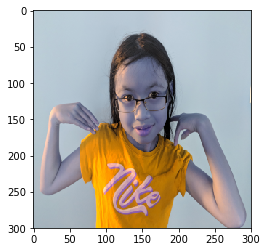

In [30]:
import warnings; warnings.simplefilter('ignore')
y_proba = np.argmax(model.predict(x_train[6].reshape(1, 300, 300, 3)))
%matplotlib inline
imgplot = plt.imshow(x_train[6])
print ('Predicted Classification:', le.inverse_transform(y_proba))

Predicted Classification: stick_tounge


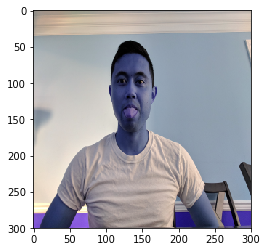

In [31]:
y_proba = np.argmax(model.predict(x_train[120].reshape(1, 300, 300, 3)))
imgplot = plt.imshow(x_train[120])
print ('Predicted Classification:', le.inverse_transform(y_proba))

Predicted Classification: cross_armsX


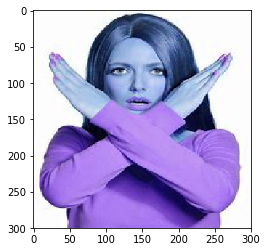

In [32]:
y_proba = np.argmax(model.predict(x_train[117].reshape(1, 300, 300, 3)))
imgplot = plt.imshow(x_train[117])
print ('Predicted Classification:', le.inverse_transform(y_proba))

Predicted Classification: angry


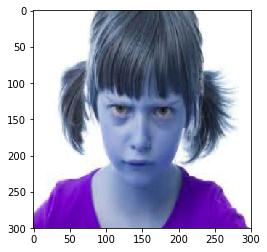

In [33]:
y_proba = np.argmax(model.predict(x_train[77].reshape(1, 300, 300, 3)))
imgplot = plt.imshow(x_train[77])
print ('Predicted Classification:', le.inverse_transform(y_proba))

### Classify video from webcam in real time - using Inception model

In [21]:
%%capture
from keras.models import load_model
model=load_model('weights_bestInception.hdf5')

cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # use the keras trained model to predict the frame's class
    frame_temp = cv2.resize(frame, (300,300), interpolation = cv2.INTER_AREA)
    frame_temp = frame_temp / 255.0
    y_proba = np.argmax(model.predict(frame_temp.reshape(1, 300, 300, 3)))

    # Our operations on the frame come here
    # set the text parameters
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10, 290)
    fontScale = 1
    fontColor = (255,255,255)
    lineType = 2
    text = le.inverse_transform(y_proba)  # this is the prediction
    cv2.putText(frame, text, bottomLeftCornerOfText, font, fontScale, 
               fontColor, lineType)

    # Display the resulting frame
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

When running the model above, we get a good classification accuracy. The only problem is that the frame rate per second is very slow. This model will not perform well when creating the Simon Says game because of the very slow frames per second.

### Training a more efficient model - Mobilenet

The above Inception model had a very high test accuracy. However, the model will not work well due to the slow frame rate classifications. Now, I will try to train Mobilenet, which is also a pre-built model but will use this to try and accomplish a faster frame per second classification.

Before I start training my model, I would have to create new training and test sets specific to the Mobilenet model. The reason for this is because MobileNet only accepts images that are 224px by 224px. Below is the code to create new training and validation image sets for my image data that meets the pixel requirement.

In [4]:
# list that has all the folder names/classifications
subfolder = ['angry', 'cross_armsX', 'flex_biceps', 'peace_sign', 'smile', 
            'stick_tounge', 'ten_fingers', 'touch_head', 'touch_nose', 'touch_shoulder']

# initialize empty pandas dataframe to store all images and respective class labels
image_df = pd.DataFrame()

# loop to read in the image data
for i in subfolder:
    path = 'D:/' + i # path to subfolder
    directory = os.listdir(path)  # read in the images in the subfolder
    
    # nested loop to read in each image in subfolder
    for k in directory:
        img = cv2.imread(path + '/' + k, 1) # read in image, convert to grayscale
        
        # resize the image to 224 width, 224 height
        img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
        
        temp_df = pd.DataFrame({'label':[i], 'image': [img]}) # pandas dataframe that holds one record of image data
        image_df = image_df.append(temp_df) # append temp_df dataframe to image_df dataframe

# reset the index of the dataframe and display head
image_df = image_df.reset_index(drop = True)
image_df.head()

# store images and labels in numpy arrays
images = np.array(list(image_df.image)) / 255.0  # divide by 255 to have smaller values
labels = np.array(image_df.label)
le = LabelEncoder()  # one hot encode the labels, needed for neural net
labels = le.fit_transform(labels)
labels = keras.utils.to_categorical(labels, num_classes=None)

# create partition of training and validation sets, 20% validation
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 3)

In the code below we are going to download the Mobilenet model with pre-trained weights from Imagenet dataset. We will remove the top layers so that we can add our own custom layers which will be trained with our own images. 

In [3]:
# Import the mobilenet model
model = applications.mobilenet.MobileNet(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

# Add layers to the pre-structured model
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(600, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(10, activation='softmax')(x) # there are 10 different image classes

model = Model(inputs=model.input, outputs=predictions)

model.summary()

17227776/17225924 [==============================] - 28s 2us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 

In [4]:
from keras.optimizers import SGD
# initialize checkpointer to save the best epoch
checkpointer = ModelCheckpoint(filepath='weights_bestMobilenet.hdf5', 
                           verbose=1, save_best_only=True)

# use image augmentation to produce higher accuracy when training
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")


# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
opt = SGD(lr=0.01)
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# train the model
model.fit_generator(aug.flow(x_train, y_train, batch_size=4),
                steps_per_epoch = len(x_train) // 4, # the number of times images are iterated through the epoch
                epochs = 20,
                validation_data=(x_val, y_val),
                verbose=1, 
                callbacks = [checkpointer])

Epoch 1/20
106/106 [==============================] - 8s 74ms/step - loss: 1.8917 - acc: 0.3561 - val_loss: 1.2284 - val_acc: 0.6542

Epoch 00001: val_loss improved from inf to 1.22837, saving model to weights_bestMobilenet.hdf5
Epoch 2/20
106/106 [==============================] - 5s 51ms/step - loss: 0.9487 - acc: 0.6863 - val_loss: 0.7054 - val_acc: 0.7383

Epoch 00002: val_loss improved from 1.22837 to 0.70543, saving model to weights_bestMobilenet.hdf5
Epoch 3/20
106/106 [==============================] - 5s 51ms/step - loss: 0.7059 - acc: 0.7524 - val_loss: 0.4113 - val_acc: 0.8224

Epoch 00003: val_loss improved from 0.70543 to 0.41134, saving model to weights_bestMobilenet.hdf5
Epoch 4/20
106/106 [==============================] - 5s 51ms/step - loss: 0.4178 - acc: 0.8608 - val_loss: 0.2797 - val_acc: 0.8785

Epoch 00004: val_loss improved from 0.41134 to 0.27974, saving model to weights_bestMobilenet.hdf5
Epoch 5/20
106/106 [==============================] - 5s 52ms/step - los

The Mobilenet model produced a validation accuracy of 96.3% compared to the validation accuracy of 99.1% with the Inception model. Although the accuracy is a little bit lower for Mobilenet, this will still be acceptable for my Simon Says application.

### Classify video from webcam in real time - using Mobilenet model

When I ran the code below, the frames per second were much faster, a lot less laggy compared to that of the Inception model. The classified images seemed just as accurate as the Inception model as well; it makes sense as the size of the model in terms of storage is much smaller than Inception. I will use this for model for my Simon Says game. The code below will open up your webcam and will classify which of the ten gestures you are doing at that time.

In [ ]:
%%capture
from keras.models import load_model
from tensorflow.python.keras._impl.keras.applications import mobilenet

# load the model
model=load_model('weights_bestMobilenet.hdf5', custom_objects={
                   'relu6': mobilenet.relu6})

cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # use the keras trained model to predict the frame's class
    frame_temp = cv2.resize(frame, (224,224), interpolation = cv2.INTER_AREA)
    frame_temp = frame_temp / 255.0
    y_proba = np.argmax(model.predict(frame_temp.reshape(1, 224, 224, 3)))

    # Our operations on the frame come here
    # set the text parameters
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10, 290)
    fontScale = 1
    fontColor = (255,255,255)
    lineType = 2
    text = le.inverse_transform(y_proba)  # this is the prediction
    cv2.putText(frame, text, bottomLeftCornerOfText, font, fontScale, 
               fontColor, lineType)

    # Display the resulting frame
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()